In [1]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt


Cost after iteration 0: 0.771749
Cost after iteration 100: 0.669270
Cost after iteration 200: 0.638874
Cost after iteration 300: 0.597884
Cost after iteration 400: 0.568827
Cost after iteration 500: 0.461260
Cost after iteration 600: 0.508484
Cost after iteration 700: 0.327596
Cost after iteration 800: 0.310398
Cost after iteration 900: 0.248831
Cost after iteration 1000: 0.207309
Cost after iteration 1100: 0.140485
Cost after iteration 1200: 0.115670
Cost after iteration 1300: 0.099260
Cost after iteration 1400: 0.085845
Cost after iteration 1500: 0.074975
Cost after iteration 1600: 0.067809
Cost after iteration 1700: 0.058402
Cost after iteration 1800: 0.052054
Cost after iteration 1900: 0.047680
Cost after iteration 2000: 0.042259
Cost after iteration 2100: 0.037797
Cost after iteration 2200: 0.034730
Cost after iteration 2300: 0.031391
Cost after iteration 2400: 0.028788


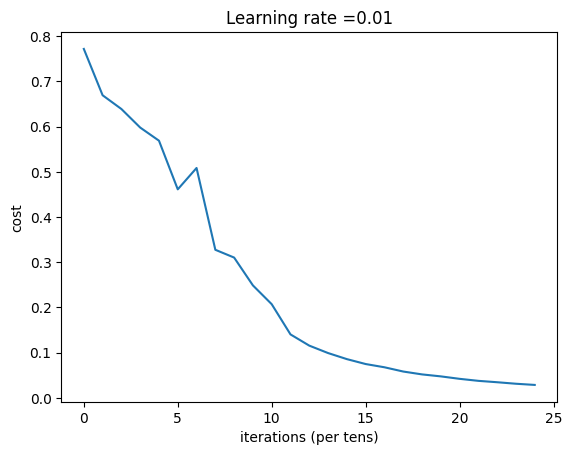

Accuracy: 0.9999999999999998
Accuracy: 0.8400000000000001


In [90]:
# from dnn_app_utils_v3 import *

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def initialize_parameters_deep(layer_dims): 
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        # parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * .01
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        # print(f"W{l} has shape {layer_dims[l], layer_dims[l-1]}")
        # print(f"b{l} has shape {layer_dims[l], 1}")
    return parameters

def linear_forward(A, W, b):
    Z = W @ A + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1 - AL).T))
    cost = np.squeeze(cost)
    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * (dZ @ A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T @ dZ
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    ind = np.where(probas[0, :] > .5)[0]
    p[0, ind] = 1
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    return p

def L_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

x_train, y_train, x_test, y_test, classes = load_data()

# ind_random = np.random.randint(0, x_train.shape[0])
# plt.imshow(x_train[ind_random])
# plt.title(classes[y_train[0, ind_random]].decode("utf-8"))
# plt.show()

x_train = x_train.reshape(x_train.shape[0], -1).T
x_test = x_test.reshape(x_test.shape[0], -1).T
x_train = x_train / 255
x_test = x_test / 255
y_train = y_train
y_test = y_test

layer_dims = [12288, 20, 7, 5, 1]

parameters = L_layer_model(x_train, y_train, layer_dims, num_iterations = 2500, print_cost = True)
pred_train = predict(x_train, y_train, parameters)
pred_test = predict(x_test, y_test, parameters)


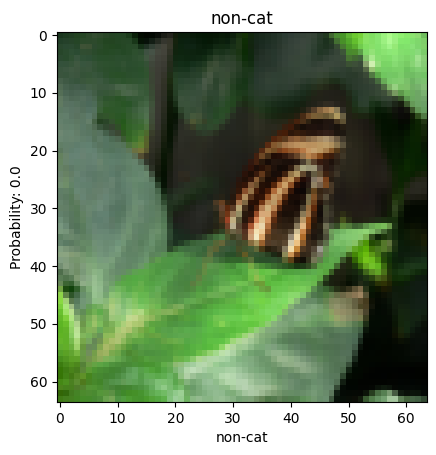

In [108]:
ind_random_test = np.random.randint(0, x_test.shape[1])
plt.imshow(x_test[:, ind_random_test].reshape(64, 64, 3))
plt.title(classes[int(pred_test[0, ind_random_test])].decode("utf-8"))
plt.xlabel(classes[y_test[0, ind_random_test]].decode("utf-8"))
plt.ylabel("Probability: " + str(pred_test[0, ind_random_test]))
plt.show()

In [50]:
n_x = x_train.shape[0]
n_y = 1
n_h = 7 
layer_dims = [n_x, n_h, n_y]

# def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
#     np.random.seed(1)
#     grads = {}
#     costs = []                              # to keep track of the cost
#     m = X.shape[1]                           # number of examples
#     (n_x, n_h, n_y) = layers_dims
#     parameters = initialize_parameters_deep(layers_dims)
#     W1 = parameters["W1"]
#     b1 = parameters["b1"]
#     W2 = parameters["W2"]
#     b2 = parameters["b2"]
#     for i in range(0, num_iterations):
#         A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
#         A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
#         cost = compute_cost(A2, Y)
#         dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
#         dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
#         dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
#         grads['dW1'] = dW1
#         grads['db1'] = db1
#         grads['dW2'] = dW2
#         grads['db2'] = db2
#         parameters = update_parameters(parameters, grads, learning_rate)
#         W1 = parameters["W1"]
#         b1 = parameters["b1"]
#         W2 = parameters["W2"]
#         b2 = parameters["b2"]
#         if print_cost and i % 100 == 0:
#             print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
#         if print_cost and i % 100 == 0:
#             costs.append(cost)
#     plt.plot(np.squeeze(costs))
#     plt.ylabel('cost')
#     plt.xlabel('iterations (per tens)')
#     plt.title("Learning rate =" + str(learning_rate))
#     plt.show()
#     return parameters

# parameters = two_layer_model(x_train, y_train, layer_dims, num_iterations = 2500, print_cost=True)
# predictions_train = predict(x_train, y_train, parameters)
# predictions_test = predict(x_test, y_test, parameters)


Cost after iteration 0: 0.771749
Cost after iteration 100: 0.669270
Cost after iteration 200: 0.638874
Cost after iteration 300: 0.597884
Cost after iteration 400: 0.568827
Cost after iteration 500: 0.461260
Cost after iteration 600: 0.508484
Cost after iteration 700: 0.327596
Cost after iteration 800: 0.310398
Cost after iteration 900: 0.248831
Cost after iteration 1000: 0.207309
Cost after iteration 1100: 0.140485
Cost after iteration 1200: 0.115670
Cost after iteration 1300: 0.099260
Cost after iteration 1400: 0.085845
Cost after iteration 1500: 0.074975
Cost after iteration 1600: 0.067809
Cost after iteration 1700: 0.058402
Cost after iteration 1800: 0.052054
Cost after iteration 1900: 0.047680
Cost after iteration 2000: 0.042259
Cost after iteration 2100: 0.037797
Cost after iteration 2200: 0.034730
Cost after iteration 2300: 0.031391
Cost after iteration 2400: 0.028788
Cost after iteration 2500: 0.026484
Cost after iteration 2600: 0.024381
Cost after iteration 2700: 0.022657
Cost

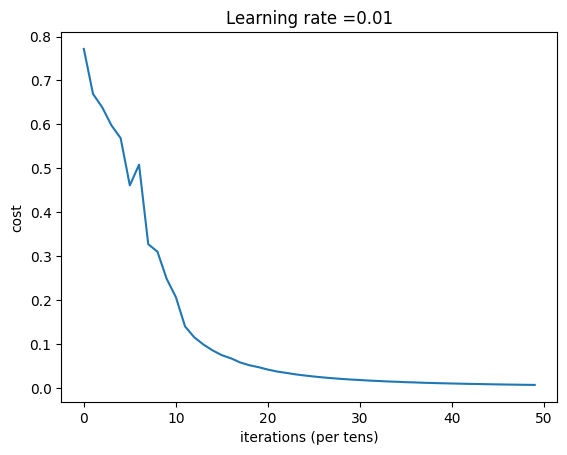

In [72]:

# from dnn_app_utils_v3 import *



Accuracy: 0.9999999999999998
Accuracy: 0.8
